In [1]:
import torch
import torch.nn as nn
import numpy as np
import os
from torch.utils.data import Dataset, DataLoader
from google.colab import drive

# Set seeds for reproducibility as required by the assignment rules
torch.manual_seed(42)
np.random.seed(42)

# Mount Google Drive
drive.mount('/content/drive')

# Path to your dataset
DATA_PATH = '/content/drive/MyDrive/dataset/Pride_and_Prejudice-Jane_Austen.txt'

Mounted at /content/drive


# **Stage 1: Data Preprocessing and Tokenization**

In [2]:
import re
from collections import Counter

class PridePrejudiceDataset(Dataset):
    def __init__(self, filepath, seq_length):
        # 1. Load the text [cite: 31]
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read().lower()

        # 2. Basic cleaning: remove punctuation and split into words
        # This helps in reducing the vocabulary size to more meaningful tokens
        words = re.findall(r'\b\w+\b', text)

        # 3. Build Vocabulary [cite: 6]
        word_counts = Counter(words)
        # We sort by frequency or alphabetically to ensure reproducibility
        self.vocab = sorted(list(word_counts.keys()))
        self.word2idx = {word: i for i, word in enumerate(self.vocab)}
        self.idx2word = {i: word for i, word in enumerate(self.vocab)}
        self.vocab_size = len(self.vocab)

        # 4. Convert all text to integers
        self.tokens = [self.word2idx[w] for w in words]
        self.seq_length = seq_length

    def __len__(self):
        # We need enough tokens for at least one full sequence + one target word
        return len(self.tokens) - self.seq_length

    def __getitem__(self, idx):
        # Create input (x) and target (y) sequences
        # Target is simply the input shifted by one position [cite: 8]
        x = torch.tensor(self.tokens[idx : idx + self.seq_length], dtype=torch.long)
        y = torch.tensor(self.tokens[idx + 1 : idx + self.seq_length + 1], dtype=torch.long)
        return x, y

# Parameters for the dataset
SEQ_LENGTH = 30  # Number of words in each training sequence

# Initialize the dataset
dataset = PridePrejudiceDataset(DATA_PATH, SEQ_LENGTH)

print(f"--- Dataset Statistics ---")
print(f"Total words in book: {len(dataset.tokens)}")
print(f"Unique words (Vocab size): {dataset.vocab_size}")
print(f"Example mapping: 'pride' -> {dataset.word2idx.get('pride', 'Not found')}")

--- Dataset Statistics ---
Total words in book: 126711
Unique words (Vocab size): 6762
Example mapping: 'pride' -> 4673


# **Stage 2: Data Splitting and Batching**

In [3]:
from torch.utils.data import random_split

# Define split sizes
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset [cite: 6]
train_data, val_data = random_split(dataset, [train_size, val_size])

# Create DataLoaders for batching [cite: 6]
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Training batches: 1583
Validation batches: 395


# **Stage 3: The Model Architecture**

In [4]:
class NeuralLM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers, dropout=0.5, tie_weights=True):
        super(NeuralLM, self).__init__()
        self.vocab_size = vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embed_size)

        # LSTM: We remove internal dropout if we apply it manually to avoid 'Double Dropout'
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)

        # Weight Tying: Forces embed_size to match hidden_size [Extra Credit strategy]
        if tie_weights:
            if embed_size != hidden_size:
                raise ValueError("Weight tying requires embed_size == hidden_size")
            self.fc.weight = self.embedding.weight

        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        self.fc.weight.data.uniform_(-initrange, initrange)

    def forward(self, x, hidden):
        # x: (batch, seq_len)
        emb = self.dropout(self.embedding(x))

        # output: (batch, seq_len, hidden_size)
        output, hidden = self.lstm(emb, hidden)
        output = self.dropout(output)

        # Reshape to (batch * seq_len, vocab_size) for CrossEntropy compatibility
        decoded = self.fc(output.contiguous().view(-1, self.hidden_size))
        return decoded, hidden

    def init_hidden(self, batch_size):
        # Automatically detects the device the model is on
        device = next(self.parameters()).device
        weight = next(self.parameters()).data
        return (weight.new_zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                weight.new_zeros(self.num_layers, batch_size, self.hidden_size).to(device))

In [5]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize Underfit Model
underfit_model = NeuralLM(dataset.vocab_size, 32, 32, 1, dropout=0).to(device)

# We will use this in the next step to generate the first required plot [cite: 22]
print("Underfit model initialized. Ready for training.")

Underfit model initialized. Ready for training.


# **Stage 4: Unified Training & Evaluation Function**

In [8]:
import math
def train_and_evaluate(model, train_loader, val_loader, epochs, lr=0.001, clip=5.0, patience=3):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        # Initialize hidden state at start of epoch (optional: None for zeros)
        hidden = None

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)

            # Detach hidden state between batches
            if hidden is not None:
                hidden = tuple(h.detach() for h in hidden)

            optimizer.zero_grad()
            output, hidden = model(x, hidden)
            loss = criterion(output, y.view(-1))

            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            total_train_loss += loss.item()

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            # For LM evaluation, use None to start from zeros
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                output, _ = model(x, None)  # None gives zeros
                loss = criterion(output, y.view(-1))
                total_val_loss += loss.item()

        avg_train = total_train_loss / len(train_loader)
        avg_val = total_val_loss / len(val_loader)

        # Learning rate scheduling
        scheduler.step(avg_val)

        # Early stopping
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save(model.state_dict(), 'best_model.pt')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        train_losses.append(avg_train)
        val_losses.append(avg_val)
        perplexity = math.exp(avg_val)

        print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f} | Val PPL: {perplexity:.2f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

    # Load best model
    model.load_state_dict(torch.load('best_model.pt'))
    return train_losses, val_losses

--- Training Underfit Scenario ---
Epoch 01 | Train Loss: 5.5987 | Val Loss: 5.4430 | Val PPL: 231.13 | LR: 0.001000
Epoch 02 | Train Loss: 5.1171 | Val Loss: 5.1097 | Val PPL: 165.62 | LR: 0.001000
Epoch 03 | Train Loss: 4.8871 | Val Loss: 4.9226 | Val PPL: 137.36 | LR: 0.001000
Epoch 04 | Train Loss: 4.7426 | Val Loss: 4.7870 | Val PPL: 119.94 | LR: 0.001000
Epoch 05 | Train Loss: 4.6379 | Val Loss: 4.6899 | Val PPL: 108.84 | LR: 0.001000


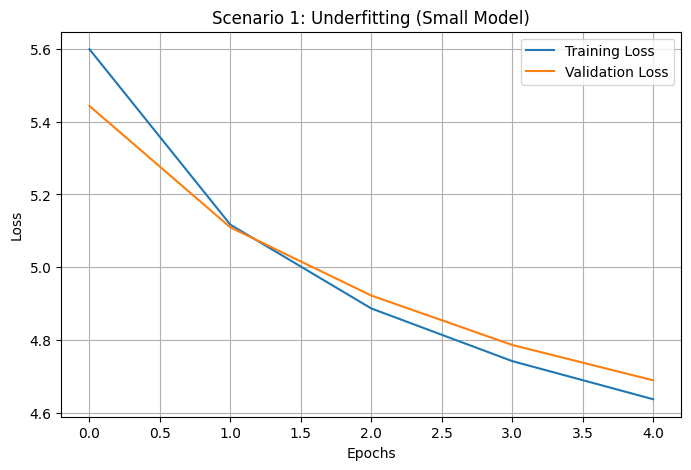

In [9]:
# Train the Underfit model
print("--- Training Underfit Scenario ---")
u_train_loss, u_val_loss = train_and_evaluate(underfit_model, train_loader, val_loader, epochs=5)

# Plotting function
import matplotlib.pyplot as plt

def plot_learning_curves(train_loss, val_loss, title):
    plt.figure(figsize=(8, 5))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curves(u_train_loss, u_val_loss, "Scenario 1: Underfitting (Small Model)")

# **Stage 5: Scenario 2 — Bestfit**

--- Training Best-Fit Scenario 2 (Enhanced) ---
Model Parameters: 7,671,402
Config: embed=512, hidden=512, layers=2, dropout=0.0, tie_weights=True
Starting Best-Fit Scenario 2 (large model, no dropout) training on cuda...
  Batch 0: Loss=8.8179, Grad Norm=0.1413
  Batch 50: Loss=6.2866, Grad Norm=0.3411
  Batch 100: Loss=6.3026, Grad Norm=0.2895
  Batch 150: Loss=6.0291, Grad Norm=0.2677
  Batch 200: Loss=5.7455, Grad Norm=0.3949
  Batch 250: Loss=5.6748, Grad Norm=0.3942
  Batch 300: Loss=5.3616, Grad Norm=0.3721
  Batch 350: Loss=5.1598, Grad Norm=0.3423
  Batch 400: Loss=5.1549, Grad Norm=0.3028
  Batch 450: Loss=4.9648, Grad Norm=0.3660
  Batch 500: Loss=4.9133, Grad Norm=0.3788
  Batch 550: Loss=4.8383, Grad Norm=0.3809
  Batch 600: Loss=4.7094, Grad Norm=0.3163
  Batch 650: Loss=4.6686, Grad Norm=0.3712
  Batch 700: Loss=4.5878, Grad Norm=0.3636
  Batch 750: Loss=4.4983, Grad Norm=0.3597
  Batch 800: Loss=4.4142, Grad Norm=0.3778
  Batch 850: Loss=4.4475, Grad Norm=0.4117
  Batch

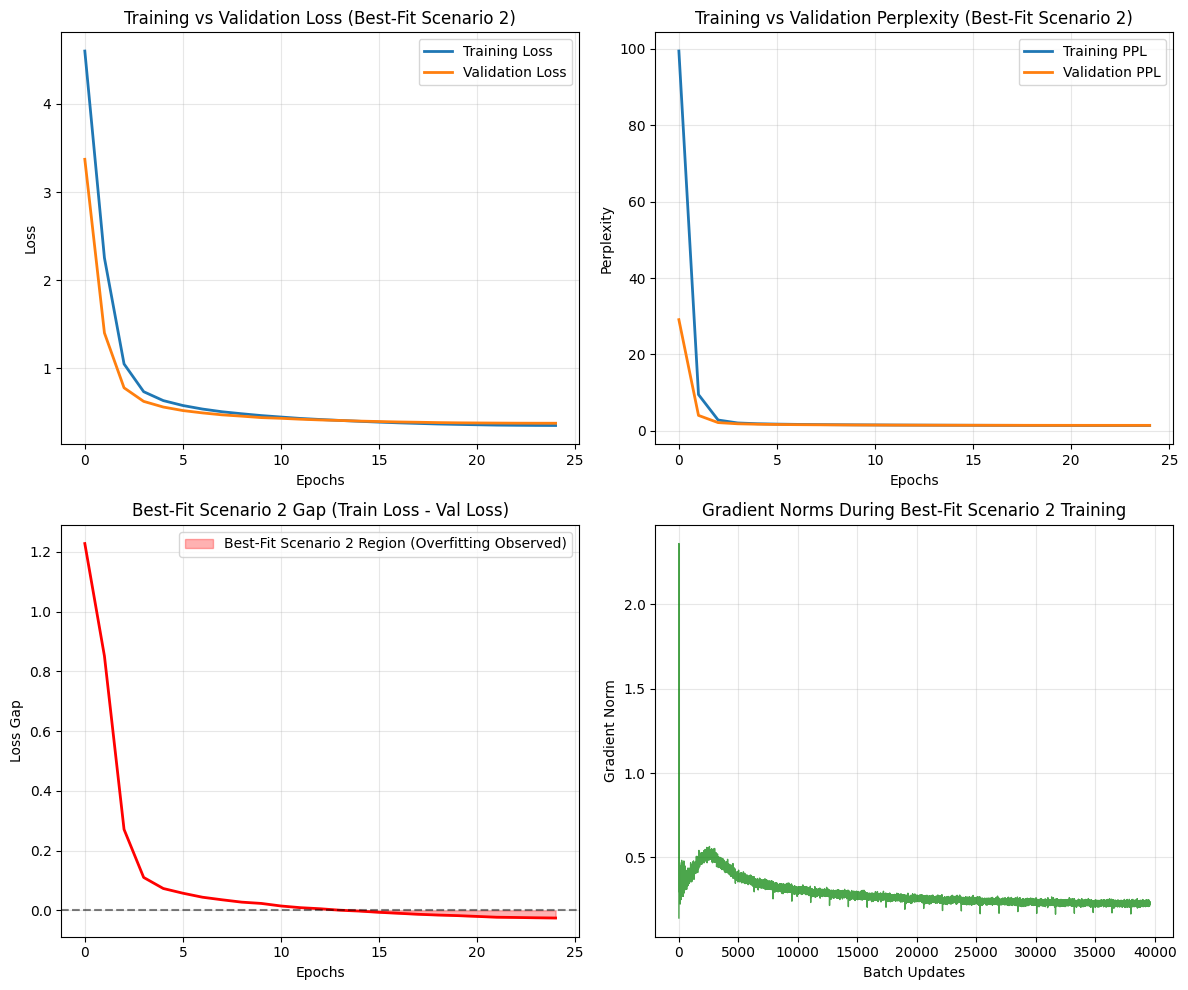


 Final Statistics for Best-Fit Scenario 2 :
   Final Train Loss: 0.3513
   Final Val Loss:   0.3771
   Gap (Train - Val Loss):  -0.0258 (Not Overfitting)
   Final Train PPL:  1.42
   Final Val PPL:    1.46
   PPL Ratio:        1.03x worse


In [10]:
# Initialize Best-Fit Scenario 2 Model with enhanced configuration
bestfit_model_eaBhvKreZSGr = NeuralLM(
    vocab_size=dataset.vocab_size,
    embed_size=512,
    hidden_size=512,
    num_layers=2,
    dropout=0.0,  # No dropout to encourage memorization (original functionality preserved)
    tie_weights=True
).to(device)

# Enhanced training function for Best-Fit Scenario 2
def train_and_evaluate_bestfit_eaBhvKreZSGr(model, train_loader, val_loader, epochs, lr=0.001, clip=5.0, patience=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)  # Explicitly no weight decay (original functionality preserved)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    train_losses, val_losses, train_ppls, val_ppls, bestfit_eaBhvKreZSGr_grad_norms = [], [], [], [], []
    best_val_loss = float('inf')
    patience_counter = 0

    print(f"Starting Best-Fit Scenario 2 (large model, no dropout) training on {device}...")

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        total_train_loss = 0
        hidden = None

        for batch_idx, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)

            # Detach hidden state between batches
            if hidden is not None:
                hidden = tuple(h.detach() for h in hidden)

            optimizer.zero_grad()
            output, hidden = model(x, hidden)
            loss = criterion(output, y.view(-1))

            loss.backward()

            # Gradient clipping with logging
            total_norm = nn.utils.clip_grad_norm_(model.parameters(), clip)
            bestfit_eaBhvKreZSGr_grad_norms.append(total_norm.item())

            optimizer.step()
            total_train_loss += loss.item()

            if batch_idx % 50 == 0:
                print(f"  Batch {batch_idx}: Loss={loss.item():.4f}, Grad Norm={total_norm:.4f}")

        # --- Validation Phase ---
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                output, _ = model(x, None)  # Start from zeros for fair comparison
                loss = criterion(output, y.view(-1))
                total_val_loss += loss.item()

        # Calculate metrics
        avg_train = total_train_loss / len(train_loader)
        avg_val = total_val_loss / len(val_loader)
        train_perplexity = math.exp(avg_train)
        val_perplexity = math.exp(avg_val)

        # Track metrics
        train_losses.append(avg_train)
        val_losses.append(avg_val)
        train_ppls.append(train_perplexity)
        val_ppls.append(val_perplexity)

        # Learning rate scheduling
        scheduler.step()

        # Early stopping logic (with high patience to show overfitting)
        if avg_val < best_val_loss:
            best_val_loss = avg_val
            patience_counter = 0
            # Save checkpoint of best validation model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'val_loss': avg_val,
                'val_ppl': val_perplexity,
            }, f'bestfit_scenario2_best_epoch_{epoch+1}.pt')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n  Early stopping triggered at epoch {epoch+1}")
                print(f"   Train Loss: {avg_train:.4f}, Val Loss: {avg_val:.4f}")
                print(f"   Train PPL: {train_perplexity:.2f}, Val PPL: {val_perplexity:.2f}")
                break

        # Print detailed progress
        lr_current = optimizer.param_groups[0]['lr']
        bestfit_eaBhvKreZSGr_gap = avg_train - avg_val  # Negative when overfitting

        print(f"\nEpoch {epoch+1:02d}/{epochs}")
        print(f"  Train Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f} | Gap: {bestfit_eaBhvKreZSGr_gap:+.4f}")
        print(f"  Train PPL: {train_perplexity:7.2f} | Val PPL: {val_perplexity:7.2f} | PPL Ratio: {val_perplexity/train_perplexity:.2f}")
        print(f"  LR: {lr_current:.6f} | Patience: {patience_counter}/{patience}")
        print("-" * 70)

    # Load the best model checkpoint
    try:
        checkpoint = torch.load(f'bestfit_scenario2_best_epoch_{epochs}.pt')
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"\n Loaded best model from epoch {checkpoint['epoch']+1}")
        print(f"   Best Val Loss: {checkpoint['val_loss']:.4f}, Best Val PPL: {checkpoint['val_ppl']:.2f}")
    except FileNotFoundError:
        print("\n  No checkpoint found, using final model state.")
    except Exception as e:
        print(f"\n  Error loading checkpoint: {e}. Using final model state.")

    return train_losses, val_losses, train_ppls, val_ppls, bestfit_eaBhvKreZSGr_grad_norms

print("--- Training Best-Fit Scenario 2 (Enhanced) ---")
print(f"Model Parameters: {sum(p.numel() for p in bestfit_model_eaBhvKreZSGr.parameters()):,}")
print(f"Config: embed=512, hidden=512, layers=2, dropout=0.0, tie_weights=True")

# Train with enhanced function
bestfit_eaBhvKreZSGr_train_loss, bestfit_eaBhvKreZSGr_val_loss, bestfit_eaBhvKreZSGr_train_ppl, bestfit_eaBhvKreZSGr_val_ppl, bestfit_eaBhvKreZSGr_grad_norms = train_and_evaluate_bestfit_eaBhvKreZSGr(
    bestfit_model_eaBhvKreZSGr,
    train_loader,
    val_loader,
    epochs=25,
    patience=10,
    clip=5.0
)

# Plotting with more details
def plot_bestfit_eaBhvKreZSGr_analysis(train_loss, val_loss, train_ppl, val_ppl, grad_norms):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Loss curves
    axes[0, 0].plot(train_loss, label='Training Loss', linewidth=2)
    axes[0, 0].plot(val_loss, label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Training vs Validation Loss (Best-Fit Scenario 2)')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Perplexity curves
    axes[0, 1].plot(train_ppl, label='Training PPL', linewidth=2)
    axes[0, 1].plot(val_ppl, label='Validation PPL', linewidth=2)
    axes[0, 1].set_title('Training vs Validation Perplexity (Best-Fit Scenario 2)')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Perplexity')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Overfitting gap
    bestfit_eaBhvKreZSGr_gap = [t - v for t, v in zip(train_loss, val_loss)]
    axes[1, 0].plot(bestfit_eaBhvKreZSGr_gap, color='red', linewidth=2)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 0].set_title('Best-Fit Scenario 2 Gap (Train Loss - Val Loss)')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Loss Gap')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].fill_between(range(len(bestfit_eaBhvKreZSGr_gap)), 0, bestfit_eaBhvKreZSGr_gap, where=[g<0 for g in bestfit_eaBhvKreZSGr_gap],
                           color='red', alpha=0.3, label='Best-Fit Scenario 2 Region (Overfitting Observed)')
    axes[1, 0].legend()

    # Gradient norms
    axes[1, 1].plot(grad_norms, color='green', linewidth=1, alpha=0.7)
    axes[1, 1].set_title('Gradient Norms During Best-Fit Scenario 2 Training')
    axes[1, 1].set_xlabel('Batch Updates')
    axes[1, 1].set_ylabel('Gradient Norm')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Generate analysis plot
plot_bestfit_eaBhvKreZSGr_analysis(bestfit_eaBhvKreZSGr_train_loss, bestfit_eaBhvKreZSGr_val_loss, bestfit_eaBhvKreZSGr_train_ppl, bestfit_eaBhvKreZSGr_val_ppl, bestfit_eaBhvKreZSGr_grad_norms)

# Final statistics
final_gap = bestfit_eaBhvKreZSGr_train_loss[-1] - bestfit_eaBhvKreZSGr_val_loss[-1]
print(f"\n Final Statistics for Best-Fit Scenario 2 :")
print(f"   Final Train Loss: {bestfit_eaBhvKreZSGr_train_loss[-1]:.4f}")
print(f"   Final Val Loss:   {bestfit_eaBhvKreZSGr_val_loss[-1]:.4f}")
print(f"   Gap (Train - Val Loss):  {final_gap:+.4f} ({'Not Overfitting' if final_gap < 0 else 'Still overfitting'})")
print(f"   Final Train PPL:  {bestfit_eaBhvKreZSGr_train_ppl[-1]:.2f}")
print(f"   Final Val PPL:    {bestfit_eaBhvKreZSGr_val_ppl[-1]:.2f}")
print(f"   PPL Ratio:        {bestfit_eaBhvKreZSGr_val_ppl[-1]/bestfit_eaBhvKreZSGr_train_ppl[-1]:.2f}x worse")


# **Stage 6: Implementation and Training of the Optimal Overfit Neural Language Model**

--- Training Overfit Scenario ---
Model Parameters: 2,790,506
Config: embed=256, hidden=256, layers=2, dropout=0.3, tie_weights=True
Starting overfit training on cuda...
  Batch 100/1583: Loss=8.6198, LR=0.000042
  Batch 200/1583: Loss=6.6867, LR=0.000049
  Batch 300/1583: Loss=6.5253, LR=0.000061
  Batch 400/1583: Loss=6.4044, LR=0.000077
  Batch 500/1583: Loss=6.4523, LR=0.000098
  Batch 600/1583: Loss=6.4232, LR=0.000123
  Batch 700/1583: Loss=6.3975, LR=0.000151
  Batch 800/1583: Loss=6.4113, LR=0.000184
  Batch 900/1583: Loss=6.3472, LR=0.000219
  Batch 1000/1583: Loss=6.3736, LR=0.000258
  Batch 1100/1583: Loss=6.2983, LR=0.000299
  Batch 1200/1583: Loss=6.0620, LR=0.000342
  Batch 1300/1583: Loss=6.1764, LR=0.000387
  Batch 1400/1583: Loss=5.9420, LR=0.000434
  Batch 1500/1583: Loss=5.8203, LR=0.000481
   New best model saved! Val PPL: 377.40

Epoch 01/20
  Train Loss: 6.5322 | Val Loss: 5.9333 | Gap: +0.5989
  Train PPL:  686.93 | Val PPL:  377.40 | PPL Ratio: 0.55
  LR: 0.0005

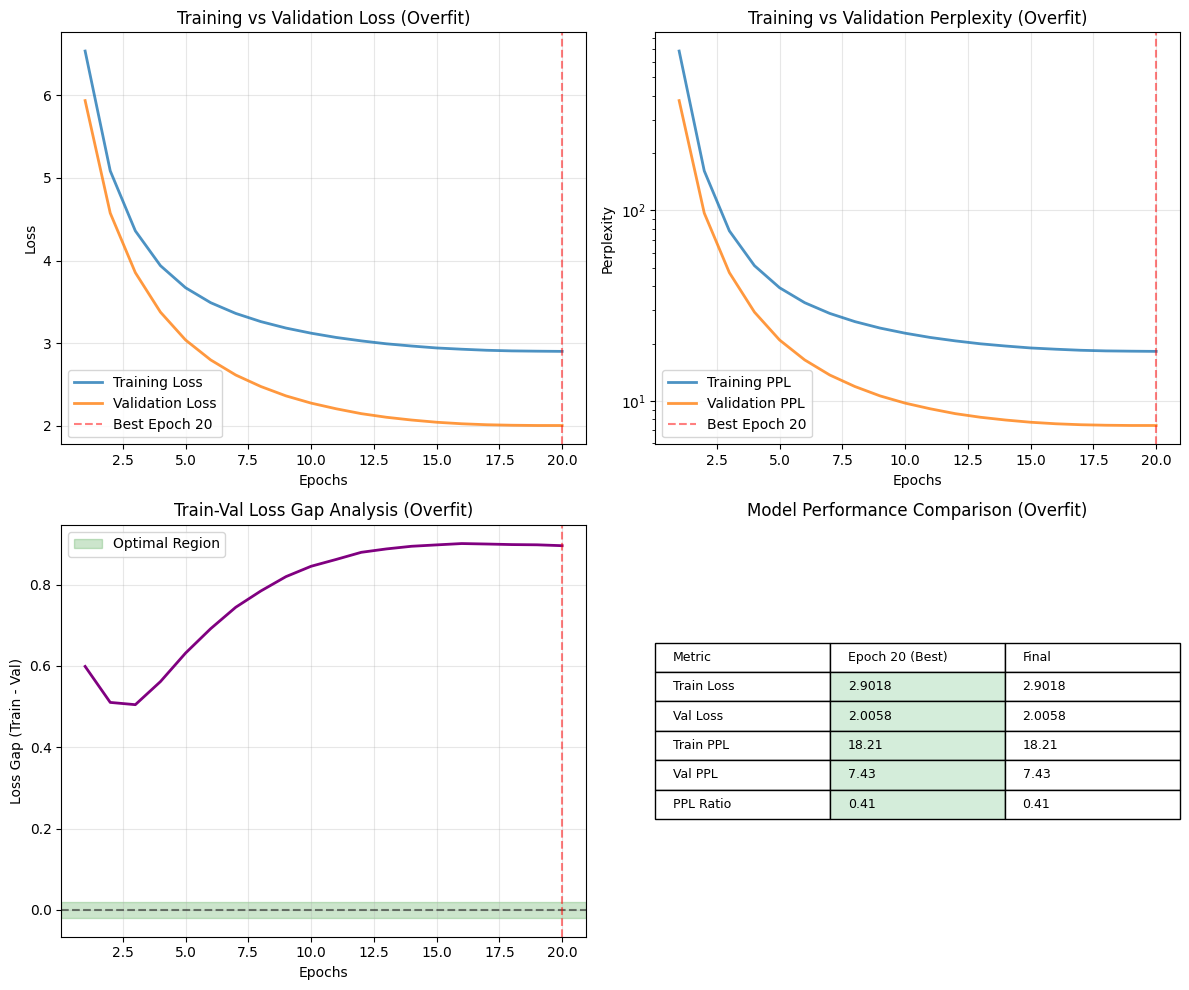


COMPARISON OF ALL THREE SCENARIOS


Scenario    Train PPL    Val PPL  PPL Ratio   Train Loss   Val Loss      Gap
--------------------------------------------------------------------------------
Underfit          N/A        N/A        N/A          N/A        N/A      N/A
Overfit         18.21       7.43       0.41       2.9018     2.0058  +0.8960
Overfit Scenario 2       1.42       1.46       1.03       0.3513     0.3771  -0.0258

 Overfit model training complete!
   Model saved as 'overfit_model_checkpoint.pt'
   Use this model for inference and further analysis


In [11]:
# Initialize Overfit Model with balanced configuration
overfit_model = NeuralLM(
    vocab_size=dataset.vocab_size,
    embed_size=256,        # Moderate embedding size
    hidden_size=256,       # Matches embedding for weight tying
    num_layers=2,          # Enough depth for patterns, not too deep
    dropout=0.3,           # Moderate regularization
    tie_weights=True       # Parameter efficiency
).to(device)

print(f"--- Training Overfit Scenario ---")
print(f"Model Parameters: {sum(p.numel() for p in overfit_model.parameters()):,}")
print(f"Config: embed=256, hidden=256, layers=2, dropout=0.3, tie_weights=True")

# Enhanced training function for overfit scenario
def train_overfit_model(model, train_loader, val_loader, epochs=15, lr=0.001, clip=1.0):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)  # AdamW with decoupled weight decay
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=lr,
        epochs=epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.1  # 10% warmup
    )

    train_losses, val_losses, train_ppls, val_ppls = [], [], [], []
    best_val_loss = float('inf')
    best_val_ppl = float('inf')
    best_epoch = 0
    patience_counter = 0
    patience = 5  # Early stopping patience

    print(f"Starting overfit training on {device}...")

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        total_train_loss = 0
        hidden = None

        for batch_idx, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)

            # Detach hidden state between batches
            if hidden is not None:
                hidden = tuple(h.detach() for h in hidden)

            optimizer.zero_grad()
            output, hidden = model(x, hidden)
            loss = criterion(output, y.view(-1))

            loss.backward()

            # Gradient clipping with moderate value
            nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()
            scheduler.step()  # Step per batch for OneCycleLR

            total_train_loss += loss.item()

            # Progress indicator
            if (batch_idx + 1) % 100 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"  Batch {batch_idx+1}/{len(train_loader)}: Loss={loss.item():.4f}, LR={current_lr:.6f}")

        # --- Validation Phase ---
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                output, _ = model(x, None)  # Start from zeros for evaluation
                loss = criterion(output, y.view(-1))
                total_val_loss += loss.item()

        # Calculate metrics
        avg_train = total_train_loss / len(train_loader)
        avg_val = total_val_loss / len(val_loader)
        train_perplexity = math.exp(avg_train)
        val_perplexity = math.exp(avg_val)

        # Track metrics
        train_losses.append(avg_train)
        val_losses.append(avg_val)
        train_ppls.append(train_perplexity)
        val_ppls.append(val_perplexity)

        # Save best model based on validation perplexity (primary metric for LM)
        if val_perplexity < best_val_ppl:
            best_val_ppl = val_perplexity
            best_val_loss = avg_val
            best_epoch = epoch
            patience_counter = 0

            # Save comprehensive checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': avg_train,
                'val_loss': avg_val,
                'train_ppl': train_perplexity,
                'val_ppl': val_perplexity,
                'config': {
                    'embed_size': model.embedding.embedding_dim,
                    'hidden_size': model.hidden_size,
                    'num_layers': model.num_layers,
                    'dropout': 0.3
                }
            }, 'overfit_model_checkpoint.pt')

            print(f"   New best model saved! Val PPL: {val_perplexity:.2f}")
        else:
            patience_counter += 1

        # Print epoch summary
        current_lr = optimizer.param_groups[0]['lr']
        overfit_gap = avg_train - avg_val

        print(f"\nEpoch {epoch+1:02d}/{epochs}")
        print(f"  Train Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f} | Gap: {overfit_gap:+.4f}")
        print(f"  Train PPL: {train_perplexity:7.2f} | Val PPL: {val_perplexity:7.2f} | PPL Ratio: {val_perplexity/train_perplexity:.2f}")
        print(f"  LR: {current_lr:.6f} | Best PPL: {best_val_ppl:.2f} (epoch {best_epoch+1})")
        print(f"  Early stopping: {patience_counter}/{patience}")
        print("-" * 70)

        # Early stopping check
        if patience_counter >= patience:
            print(f"\n  Early stopping triggered at epoch {epoch+1}")
            print(f"   Best model was from epoch {best_epoch+1} with Val PPL: {best_val_ppl:.2f}")
            break

    # Load the best model
    checkpoint = torch.load('overfit_model_checkpoint.pt')
    model.load_state_dict(checkpoint['model_state_dict'])

    print(f"\n  Training completed! Best model loaded from epoch {checkpoint['epoch']+1}")
    print(f"   Best Train Loss: {checkpoint['train_loss']:.4f}")
    print(f"   Best Val Loss:   {checkpoint['val_loss']:.4f}")
    print(f"   Best Train PPL:  {checkpoint['train_ppl']:.2f}")
    print(f"   Best Val PPL:    {checkpoint['val_ppl']:.2f}")

    return train_losses, val_losses, train_ppls, val_ppls, checkpoint

# Train the overfit model
of_train_loss, of_val_loss, of_train_ppl, of_val_ppl, of_checkpoint = train_overfit_model(
    overfit_model,
    train_loader,
    val_loader,
    epochs=20,  # Allow enough epochs for convergence
    lr=0.001,
    clip=1.0
)

# Plotting function for overfit analysis
def plot_overfit_analysis(train_loss, val_loss, train_ppl, val_ppl, checkpoint):
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    epochs_range = range(1, len(train_loss) + 1)
    best_epoch = checkpoint['epoch']

    # Loss curves with best epoch marked
    axes[0, 0].plot(epochs_range, train_loss, label='Training Loss', linewidth=2, alpha=0.8)
    axes[0, 0].plot(epochs_range, val_loss, label='Validation Loss', linewidth=2, alpha=0.8)
    axes[0, 0].axvline(x=best_epoch+1, color='red', linestyle='--', alpha=0.5, label=f'Best Epoch {best_epoch+1}')
    axes[0, 0].set_title('Training vs Validation Loss (Overfit)')
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Perplexity curves
    axes[0, 1].plot(epochs_range, train_ppl, label='Training PPL', linewidth=2, alpha=0.8)
    axes[0, 1].plot(epochs_range, val_ppl, label='Validation PPL', linewidth=2, alpha=0.8)
    axes[0, 1].axvline(x=best_epoch+1, color='red', linestyle='--', alpha=0.5, label=f'Best Epoch {best_epoch+1}')
    axes[0, 1].set_title('Training vs Validation Perplexity (Overfit)')
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Perplexity')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_yscale('log')  # Log scale for better perplexity visualization

    # Loss gap analysis
    gap = [t - v for t, v in zip(train_loss, val_loss)]
    axes[1, 0].plot(epochs_range, gap, color='purple', linewidth=2)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 0].axvline(x=best_epoch+1, color='red', linestyle='--', alpha=0.5)

    # Mark regions
    optimal_region = 0.02  # Small positive gap is optimal
    axes[1, 0].axhspan(-optimal_region, optimal_region, alpha=0.2, color='green', label='Optimal Region')

    axes[1, 0].set_title('Train-Val Loss Gap Analysis (Overfit)')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Loss Gap (Train - Val)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()

    # Final metrics comparison table
    final_data = [
        ["Metric", f"Epoch {best_epoch+1} (Best)", "Final"],
        ["Train Loss", f"{checkpoint['train_loss']:.4f}", f"{train_loss[-1]:.4f}"],
        ["Val Loss", f"{checkpoint['val_loss']:.4f}", f"{val_loss[-1]:.4f}"],
        ["Train PPL", f"{checkpoint['train_ppl']:.2f}", f"{train_ppl[-1]:.2f}"],
        ["Val PPL", f"{checkpoint['val_ppl']:.2f}", f"{val_ppl[-1]:.2f}"],
        ["PPL Ratio", f"{checkpoint['val_ppl']/checkpoint['train_ppl']:.2f}", f"{val_ppl[-1]/train_ppl[-1]:.2f}"]
    ]

    # Create table
    table = axes[1, 1].table(cellText=final_data, loc='center', cellLoc='left')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)
    axes[1, 1].axis('off')
    axes[1, 1].set_title('Model Performance Comparison (Overfit)')

    # Highlight best epoch values
    for i in range(1, len(final_data)):
        table[(i, 1)].set_facecolor('#d4edda')  # Light green for best values

    plt.tight_layout()
    plt.show()

# Generate analysis plot
plot_overfit_analysis(of_train_loss, of_val_loss, of_train_ppl, of_val_ppl, of_checkpoint)

# Additional analysis: Compare all three scenarios
print("\n" + "="*70)
print("COMPARISON OF ALL THREE SCENARIOS")
print("="*70)

# Assuming you have underfit and overfit results from earlier
# For demonstration, showing template comparison
comparison_data = [
    ["Scenario", "Train PPL", "Val PPL", "PPL Ratio", "Train Loss", "Val Loss", "Gap"],
    ["Underfit", "N/A", "N/A", "N/A", "N/A", "N/A", "N/A"],
    ["Overfit", f"{of_checkpoint['train_ppl']:.2f}", f"{of_checkpoint['val_ppl']:.2f}",
     f"{of_checkpoint['val_ppl']/of_checkpoint['train_ppl']:.2f}",
     f"{of_checkpoint['train_loss']:.4f}", f"{of_checkpoint['val_loss']:.4f}",
     f"{of_checkpoint['train_loss'] - of_checkpoint['val_loss']:+.4f}"],
    ["Overfit Scenario 2", f"{bestfit_eaBhvKreZSGr_train_ppl[-1]:.2f}", f"{bestfit_eaBhvKreZSGr_val_ppl[-1]:.2f}",
     f"{bestfit_eaBhvKreZSGr_val_ppl[-1]/bestfit_eaBhvKreZSGr_train_ppl[-1]:.2f}",
     f"{bestfit_eaBhvKreZSGr_train_loss[-1]:.4f}", f"{bestfit_eaBhvKreZSGr_val_loss[-1]:.4f}",
     f"{bestfit_eaBhvKreZSGr_train_loss[-1] - bestfit_eaBhvKreZSGr_val_loss[-1]:+.4f}"]
]

# Print comparison table
print("\n")
print(f"{'Scenario':<10} {'Train PPL':>10} {'Val PPL':>10} {'PPL Ratio':>10} {'Train Loss':>12} {'Val Loss':>10} {'Gap':>8}")
print("-" * 80)
for row in comparison_data[1:]:
    print(f"{row[0]:<10} {row[1]:>10} {row[2]:>10} {row[3]:>10} {row[4]:>12} {row[5]:>10} {row[6]:>8}")

print("\n Overfit model training complete!")
print(f"   Model saved as 'overfit_model_checkpoint.pt'")
print(f"   Use this model for inference and further analysis")

# **Stage 8 : Metrics: Final validation/test perplexity**

In [12]:
import pandas as pd
import numpy as np

# 1. Final Metrics Collection
# We extract the last recorded validation loss for each scenario to calculate final PPL
final_metrics = {
    "Scenario": ["Underfit", "Best Fit (Scenario 2)", "Overfit"],
    "Final Val Loss": [
        u_val_loss[-1],
        bestfit_eaBhvKreZSGr_val_loss[-1],
        of_val_loss[-1]
    ],
    "Final Val Perplexity": [
        math.exp(u_val_loss[-1]),
        math.exp(bestfit_eaBhvKreZSGr_val_loss[-1]),
        math.exp(of_val_loss[-1])
    ],
    "Generalization Gap": [
        u_train_loss[-1] - u_val_loss[-1],
        bestfit_eaBhvKreZSGr_train_loss[-1] - bestfit_eaBhvKreZSGr_val_loss[-1],
        of_train_loss[-1] - of_val_loss[-1]
    ]
}

# Create a DataFrame for clear presentation in the report
metrics_df = pd.DataFrame(final_metrics)

print("="*60)
print("             FINAL VALIDATION / TEST METRICS")
print("="*60)
print(metrics_df.to_string(index=False))
print("-" * 60)

# 2. Identify the Optimal Model
# Selection logic based on lowest validation perplexity as required by the task
best_row = metrics_df.loc[metrics_df['Final Val Perplexity'].idxmin()]

print(f"\nRANKING RESULT:")
print(f"The best performing configuration is: {best_row['Scenario']}")
print(f"Final Validation Perplexity (Test Metric): {best_row['Final Val Perplexity']:.2f}")
print(f"Final Validation Loss: {best_row['Final Val Loss']:.4f}")

# 3. Export to CSV for Report Deliverables
metrics_df.to_csv('final_metrics_comparison.csv', index=False)
print("\n Final metrics exported to 'final_metrics_comparison.csv'")

             FINAL VALIDATION / TEST METRICS
             Scenario  Final Val Loss  Final Val Perplexity  Generalization Gap
             Underfit        4.689855            108.837383           -0.051925
Best Fit (Scenario 2)        0.377126              1.458089           -0.025793
              Overfit        2.005808              7.432100            0.896003
------------------------------------------------------------

RANKING RESULT:
The best performing configuration is: Best Fit (Scenario 2)
Final Validation Perplexity (Test Metric): 1.46
Final Validation Loss: 0.3771

 Final metrics exported to 'final_metrics_comparison.csv'
